<a href="https://colab.research.google.com/github/lc0/deeplearning-playground/blob/master/TF2/tf2_tiff_images_dataset_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tf-nightly-gpu-2.0-preview

     |████████████████████████████████| 369.5MB 51kB/s 
     |████████████████████████████████| 450kB 37.1MB/s 
     |████████████████████████████████| 61kB 19.0MB/s 
     |████████████████████████████████| 3.2MB 29.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/51/3e/a3/b351fae0cbf15373c2136a54a70f43fea5fe91d8168a5faaa4
Successfully built opt-einsum


# Data

## initial training dataset

In [11]:
from google.colab import files

uploaded = files.upload()

Saving photomask_trainingdata.zip to photomask_trainingdata.zip


In [12]:
!ls -la

total 3192
drwxr-xr-x 1 root root    4096 Jun 28 12:17 .
drwxr-xr-x 1 root root    4096 Jun 28 12:06 ..
drwxr-xr-x 1 root root    4096 Jun 18 16:14 .config
-rw-r--r-- 1 root root 3249054 Jun 28 12:18 photomask_trainingdata.zip
drwxr-xr-x 1 root root    4096 Jun 18 16:14 sample_data


In [13]:
!unzip photomask_trainingdata.zip -d dataset

Archive:  photomask_trainingdata.zip
   creating: dataset/photomask_trainingdata/
   creating: dataset/photomask_trainingdata/COMPLETE FEATURE/
  inflating: dataset/photomask_trainingdata/COMPLETE FEATURE/026_2.tif  
   creating: dataset/__MACOSX/
   creating: dataset/__MACOSX/photomask_trainingdata/
   creating: dataset/__MACOSX/photomask_trainingdata/COMPLETE FEATURE/
  inflating: dataset/__MACOSX/photomask_trainingdata/COMPLETE FEATURE/._026_2.tif  
  inflating: dataset/photomask_trainingdata/COMPLETE FEATURE/002_3.tif  
  inflating: dataset/__MACOSX/photomask_trainingdata/COMPLETE FEATURE/._002_3.tif  
  inflating: dataset/photomask_trainingdata/COMPLETE FEATURE/020_4.tif  
  inflating: dataset/__MACOSX/photomask_trainingdata/COMPLETE FEATURE/._020_4.tif  
  inflating: dataset/photomask_trainingdata/COMPLETE FEATURE/004_4.tif  
  inflating: dataset/__MACOSX/photomask_trainingdata/COMPLETE FEATURE/._004_4.tif  
  inflating: dataset/photomask_trainingdata/COMPLETE FEATURE/019_1.tif  

In [0]:
rm -r dataset/__MACOSX/

## TF Dataset based on the files

In [0]:
dataset_path = 'dataset/photomask_trainingdata/'

In [7]:
!ls -la {dataset_path}

total 20
drwxrwxrwx 5 root root 4096 Feb  5 17:17  .
drwxr-xr-x 3 root root 4096 Jun 28 12:18  ..
drwxrwxrwx 2 root root 4096 Feb  5 17:04  BORDERTOUCHER
drwxrwxrwx 2 root root 4096 Feb  5 17:05 'COMPLETE FEATURE'
drwxrwxrwx 2 root root 4096 Feb  5 17:04 'NO FEATURE'


In [8]:
import tensorflow as tf

tf.version.VERSION

'2.0.0-beta1'

In [0]:
work_image_size = [28, 28]

batch_size = 16

In [0]:
from os import listdir, path

class_names = listdir(dataset_path)
# print(class_names)

class_folders = [(idx, path.join(dataset_path, class_name)) for idx, class_name in enumerate(class_names)]
# print(class_folders)

In [11]:
filenames = []
class_ids = []
for class_id, folder in class_folders:
  files = listdir(folder)
  
  filenames.extend([path.join(folder, filename) for filename in listdir(folder)])
  class_ids.extend([class_id for filename in listdir(folder)])


print(len(filenames))
assert len(class_ids) == len(class_ids)

111


Unfortunately `tf.py_function` can only return a tuple. With generic `map` we can work with `dict` interface

In [0]:
from PIL import Image
import numpy as np

def parse_tiff_py(filename, class_id):
    print(filename.numpy())
    
    im = Image.open(filename.numpy())
    im = im.resize(work_image_size)
    
    return np.array(im), class_id

Now we just need to add our python function to `dataset` pipeline. We can do with follow `lambda` trick

In [27]:
dataset = tf.data.Dataset.from_tensor_slices((filenames, class_ids))
dataset = dataset.shuffle(len(filenames))

dataset = dataset.map(lambda filename, label: tf.py_function(
              parse_tiff_py, 
              (filename, label),  
              [tf.uint8, label.dtype])
          )

dataset

<MapDataset shapes: (<unknown>, <unknown>), types: (tf.uint8, tf.int32)>

In [31]:
for row in dataset.take(1):
  print(row)
  image = row[0]
  label = row[1]
  
  print(image.shape)

b'dataset/photomask_trainingdata/COMPLETE FEATURE/024_2.tif'
(<tf.Tensor: id=216, shape=(28, 28), dtype=uint8, numpy=
array([[ 33,  18,  75,  51,  39,  53,  96,  94,  70,  86,  59,  27,  95,
         41,  48,  71,  96,  80,  71,  60,  71,  61,  75,  61,  38,  42,
         40,  14],
       [ 79,  30,  58,  36,  40,  35,  39,  40,  82,  39,  72,  24,  45,
         52,  48,  93,  22,  77,  48,  29,  97,  43,  81,  42,  66,  37,
         65,  81],
       [ 61,  44,  62,  61,  50,  65,  86,  41,  16, 103, 101,  73,  78,
         55,  39,  32,  70,  69,  46,  50,  19,  36,  53,  39,  65,  23,
         41,  67],
       [ 41,  65,  52,  18,  64,  38,  70,  46,  26,  59,  50,  48,  98,
         60,  66,  84, 114,  44,  84,  73,  59,  63,  31,  23,  44,  30,
         50,  48],
       [ 35,  16,  40,  90,  25,  34,  32,  77,  46,  49, 124,  99,  72,
         52,  87,  13,  83,  43,  41,  70,  67,  70,  83,  64,  97,  35,
         49,  41],
       [ 82,  66,  44,  30,  38,  49,  40,  57,  45,  24,

(28, 28)
Label - BORDERTOUCHER


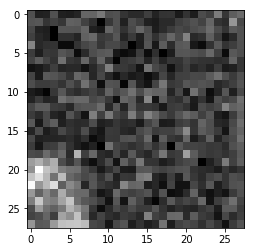

In [15]:
import matplotlib.pyplot as plt

print(image.shape)
plt.imshow(image, cmap=plt.get_cmap("gray"))

print(f"Label - {class_names[label]}")

# TemsorFlow Addons

In [25]:
!pip install tensorflow-io-2.0-preview

     |████████████████████████████████| 54.4MB 1.9MB/s 
     |████████████████████████████████| 87.9MB 30.0MB/s 
     |████████████████████████████████| 3.1MB 30.5MB/s 
     |████████████████████████████████| 501kB 42.0MB/s 
  Found existing installation: tb-nightly 1.14.0a20190614
    Uninstalling tb-nightly-1.14.0a20190614:
      Successfully uninstalled tb-nightly-1.14.0a20190614
  Found existing installation: tensorflow 1.14.0rc1
    Uninstalling tensorflow-1.14.0rc1:
      Successfully uninstalled tensorflow-1.14.0rc1


In [0]:
from tensorflow_io.image import TIFFDataset

In [0]:
dataset = TIFFDataset(filenames)
dataset = dataset.shuffle(len(filenames))

In [68]:
for image in dataset.take(4):
  print(image.shape)

(131, 131, 4)
(194, 194, 4)
(123, 123, 4)
(86, 86, 4)


(86, 86, 4)


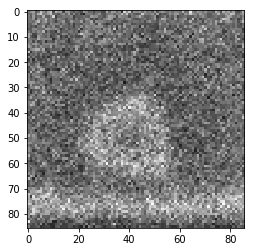

In [69]:
print(image.shape)
plt.imshow(image.numpy(), cmap=plt.get_cmap("gray"))